In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/MyDrive/Colab Notebooks/Unet_multiClass/Unet

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Unet_multiClass/Unet


In [2]:
#encoding:utf-9
from model_mobilenet import *
from data import *
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
#import keras.backend.tensorflow_backend as K
import matplotlib.pyplot as plt

#config = tf.compat.v1.ConfigProto
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)
#K.set_session(sess)
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10949980560598503666
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5245134323026908245
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
# GPU testing
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
if __name__ == '__main__':

    #path to images which are prepared to train a model
    train_path = "data/balanced_classes/train"
    image_folder = "images"
    label_folder = "labels"
    valid_path =  "data/balanced_classes/validation"
    valid_image_folder ="val_imgs"
    valid_label_folder = "val_labels"
    log_filepath = './log'
    flag_multi_class = True
    num_classes = 5
    batch_size = 6
    dp = data_preprocess(train_path=train_path,image_folder=image_folder,label_folder=label_folder,
                         valid_path=valid_path,valid_image_folder=valid_image_folder,valid_label_folder=valid_label_folder,
                         flag_multi_class=flag_multi_class,
                         num_classes=num_classes)
    
    # train your own model
    train_data = dp.trainGenerator(batch_size)
    valid_data = dp.validLoad(batch_size)
    test_data = dp.testGenerator()
    model = unet_trans(num_class=num_classes)

    # callbacks 
    callbacks_list = [
                      TensorBoard(log_dir=log_filepath),
                      keras.callbacks.EarlyStopping(
                          monitor='loss',
                          # mode="max",
                          patience=3,
                      ),
                      keras.callbacks.ModelCheckpoint('./model/micro_model_v1.hdf5', 
                                                      monitor='val_loss',verbose=1,
                                                      save_best_only=True),
    ]

    
    
    
    tb_cb = TensorBoard(log_dir=log_filepath)
    model_checkpoint = keras.callbacks.ModelCheckpoint('./model/micro_model_v1.hdf5', monitor='val_loss',verbose=1,save_best_only=True)
    history = model.fit_generator(train_data,
                                 steps_per_epoch=20,
                                 epochs=200,
                                validation_steps=5,
                                validation_data=valid_data,
                                callbacks=callbacks_list)
    

# Save the model
model.save('phyto_new_transfer.h5')

Found 125 images belonging to 1 classes.
Found 125 images belonging to 1 classes.
Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.7060 - dice_coef: 0.2361 - recall: 0.0083 - precision: 0.0546Found 34 images belonging to 1 classes.
Found 34 images belonging to 1 classes.
20/20 [==============================] - 23s 444ms/step - loss: 0.7060 - dice_coef: 0.2361 - recall: 0.0083 - precision: 0.0546 - val_loss: 0.7351 - val_dice_coef: 0.0172 - val_recall: 0.0155 - val_precision: 0.0183

Epoch 00001: val_loss improved from inf to 0.73508, saving model to ./model/micro_model_v1.hdf5
Epoch 2/200
20/20 [==============================] - 9s 392ms/step - loss: 0.6870 - dice_coef: 0.3816 - recall: 0.2965 - precision: 0.8770 - val_loss: 0.7343 - val_dice_coef: 0.0218 - val_recall: 0.0199 - val_precision: 0.0219

Epoch 00002: val_loss improved from 0.73508 to 0.73433, saving model to ./model/micro_model_v1.hdf5
Epoch 3/200
20/20 [==============================] - 8s 394ms/ste

In [ ]:
#from model_v2 import TverskyLoss

saved_model = tf.keras.models.load_model('phyto_new_10_june.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef, 'iou_coef': iou_coef})

In [ ]:
# scoreSeg = saved_model.evaluate_generator(validation_generator, steps=66)
print(valid_data)
score = saved_model.evaluate_generator(valid_data)


<generator object data_preprocess.validLoad at 0x7f48c38ec650>


NameError: ignored

KeyError: ignored

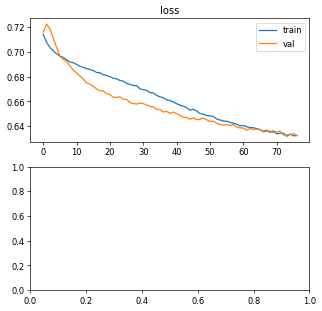

In [15]:
# draw the loss and accuracy curve
plt.figure(12, figsize=(6, 6), dpi=60)
plt.subplot(211)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
plt.title('acc')
plt.legend()

plt.show()

Found 26 images belonging to 1 classes.
Found 26 images belonging to 1 classes.


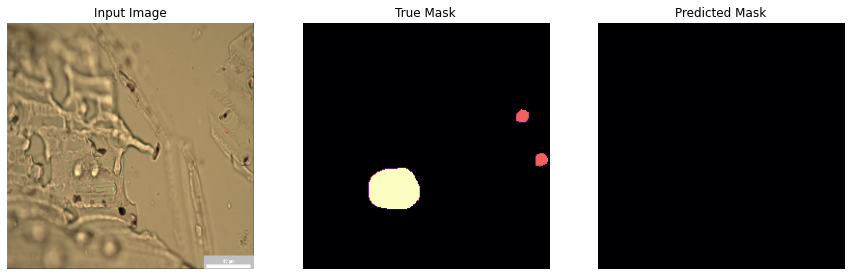

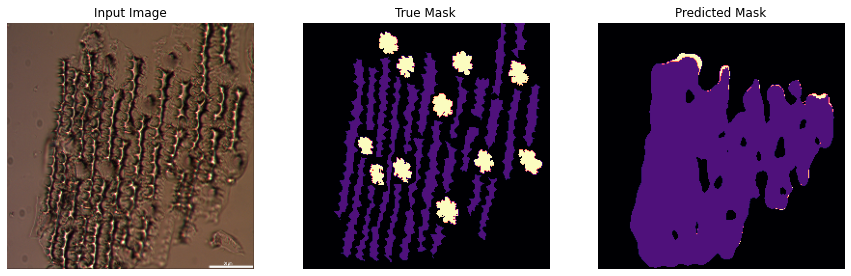

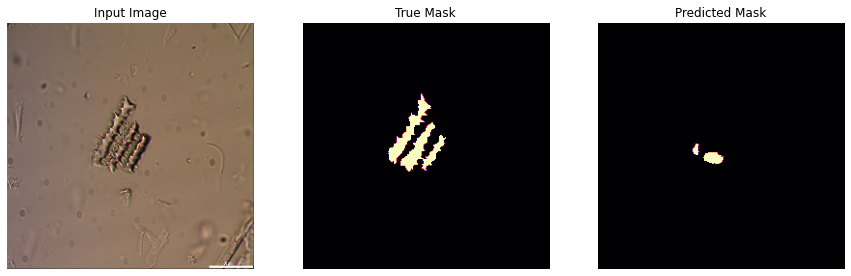

In [32]:
# This cell is the same with the predict.py code. I retyped it here because during the experiments
# I want to change the parameters without restarting the kernel

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

target_size = (256, 256)
seed = np.random.randint(0,1e5)

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator()

test_image_generator = image_datagen.flow_from_directory('data/balanced_classes/test/test_images', seed=seed, target_size=target_size, class_mode=None, batch_size =6)
test_mask_generator = mask_datagen.flow_from_directory('data/balanced_classes/test/test_labels', seed=seed, target_size=target_size, class_mode=None, batch_size = 6)

def combine_generator(gen1, gen2, batch_list=6,training=True):
  
    while True:
        image_batch, label_batch=next(gen1)[0], np.expand_dims(next(gen2)[0][:,:,0],axis=-1)
        image_batch, label_batch=np.expand_dims(image_batch,axis=0),np.expand_dims(label_batch,axis=0)

        for i in range(batch_list-1):
            image_i,label_i = next(gen1)[0], np.expand_dims(next(gen2)[0][:,:,0],axis=-1)
            
            image_i, label_i=np.expand_dims(image_i,axis=0),np.expand_dims(label_i,axis=0)
            image_batch=np.concatenate([image_batch,image_i],axis=0)
            label_batch=np.concatenate([label_batch,label_i],axis=0)
              
        yield((image_batch,label_batch))

test_generator = combine_generator(test_image_generator, test_mask_generator,training=True)


def show_predictions_in_test(model_name, generator=None, num=3):
    if generator ==None:
        generator = test_generator
    for i in range(num):
        image, mask=next(generator)
        sample_image, sample_mask= image[1], mask[1]
        image = np.expand_dims(sample_image, axis=0)
        pr_mask = model_name.predict(image)
        pr_mask=np.expand_dims(pr_mask[0].argmax(axis=-1),axis=-1)
        display([sample_image, sample_mask,pr_mask])
        
def display(display_list,title=['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='magma')
        plt.axis('off')
    plt.show()

show_predictions_in_test(model)